In [1]:
# Import libraries
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import numpy as np
import os
import matplotlib.pyplot as plt

# Import local
from BostonHarbor_Model import CVAE

# Use Cuda if possible
print("Cuda available?  {}".format(torch.cuda.is_available()))
print("Cuda version: {}".format(torch.version.cuda))
try:
    device = torch.device("cuda")
    torch.ones(5).to("cuda")
except:
    print("Cuda failed to work! Using CPU...")
    device = torch.device("cpu")

Cuda available?  True
Cuda version: 10.2


In [2]:
# Options
TRAIN_MODEL = True # Train? or just test existing?
SAVE_MODEL = False  # Should save the model?
MODEL_PATH = "BostonHarbor_example.pt"
printFreq = 25
maxSamples = 300000  # Because all samples may crash

# Hyperparams: training
trainProp = 0.8
batchSize = 256
epochs = 1000
learnRate = 1e-4

# Hyperparams: network
hiddenEncoderSize = 512    # 512 gave good loss, poor latent
hiddenDecoderSize = 512   # 512
latentSize = 3

# Raster
rasterFile = "BostonHarborData/data/full_shrink.asc"
occGrid = np.loadtxt(rasterFile, skiprows=6) # First 6 are metadata
occShape = occGrid.shape

In [3]:
#Load data
dataFile = "BostonHarbor_Data.npz"
data = np.load(dataFile)
data = data["data"][:maxSamples,:].astype("float16")

# X : start (row, col)
xData = data[:,0:2]

# C: init (row, col), goal (row, col)
cData = data[:,2:6]

# Normalize coordinates
xData[:, 0] = xData[:, 0] / occShape[0]
xData[:, 1] = xData[:, 1] / occShape[1]
cData[:, 0] = cData[:, 0] / occShape[0]
cData[:, 1] = cData[:, 1] / occShape[1]
cData[:, 2] = cData[:, 2] / occShape[0]
cData[:, 3] = cData[:, 3] / occShape[1]

nEntries = xData.shape[0]

# Split into train, test
nTrain = int(nEntries * trainProp)
xTrain = xData[0:nTrain, :]
cTrain = cData[0:nTrain, :]
xTest  = xData[nTrain:, ]
cTest  = cData[nTrain:, ] 

print("Loaded data:")
print("  File: {}".format(dataFile))
print("  Samples (x) shape: {}".format(xData.shape))
print("  Conditions (c) shape: {}".format(cData.shape))
print("  Training: {},   testing: {}".format(xTrain.shape[0], 
                                             xTest.shape[0]))

Loaded data:
  File: BostonHarbor_Data.npz
  Samples (x) shape: (300000, 2)
  Conditions (c) shape: (300000, 4)
  Training: 240000,   testing: 60000


In [4]:
# Create data loaders
def makeDataLoader(x, c, batchSize, shuffle=False):
    xTensor = torch.Tensor(x)
    cTensor = torch.Tensor(c)
    dataset = TensorDataset(xTensor, cTensor)
    dataLoader  = DataLoader(dataset, batch_size=batchSize, shuffle=shuffle)
    return xTensor, cTensor, dataset, dataLoader
    
xTrainTensor, cTrainTensor, trainDataset, trainDataLoader = \
    makeDataLoader(xTrain, cTrain, batchSize, shuffle=True)

xTestTensor, cTestTensor, testDataset, testDataLoader = \
    makeDataLoader(xTest, cTest, batchSize, shuffle=False)

## Train

In [5]:
# Define loss function
def loss_fn(reconstructed_x, x, mu, logvar):
    # Reconstruction + KL divergence loss 

    def MSE(pred, target):
        
        #return torch.sum((pred - target) ** 2)
        return torch.mean((pred - target) ** 2)
    
    # Reconstruction loss
#     recon_loss = weightedMSE(reconstructed_x, x, weight)
    recon_loss = MSE(reconstructed_x, x)
    
    # KL divergence loss
    KL_loss = 10**-4 * 2 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, 1)
    
    return torch.mean(recon_loss + KL_loss)


# Define batch training
def train(model, optimizer, dataLoader, device="cpu"):
    model.to(device)
    model.train()
    train_loss = 0
    for batch_idx, (X, C) in enumerate(dataLoader):
        X, C = X.to(device), C.to(device)
        q_z, logvar, mu, z = model(X, C)
        optimizer.zero_grad()
        cvae_loss = loss_fn(q_z, X, mu, logvar) 
        cvae_loss.backward()
        optimizer.step()
        train_loss += cvae_loss
    return train_loss / batchSize
    

# Define batch testing
def test(model, dataLoader, device="cpu"):
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (X, C) in enumerate(dataLoader):
            X, C = X.to(device), C.to(device)
            q_z, logvar, mu, z = model(X, C)
            cvae_loss = loss_fn(q_z, X, mu, logvar)
            test_loss += cvae_loss
    return test_loss / batchSize

In [6]:
# Init model
model = CVAE(
    sample_size = xTrain.shape[1],
    condition_size = cTrain.shape[1],
    hidden_encoder_size = hiddenEncoderSize,
    hidden_decoder_size = hiddenDecoderSize,
    latent_size = latentSize,
).to(device)

# Init optimizer
optimizer = optim.Adam(model.parameters(), lr=learnRate)

In [7]:
def printModelOut(model, dataLoader, nPrint=10, device="cpu"):
    X, C = next(iter(trainDataLoader))
    X, C = X.to(device), C.to(device)
    q_z, logvar, mu, z = model(X, C)
    for i in range(nPrint):
        print("({:.6f}, {:.6f})  -->  ({:.6f}, {:.6f})".format(
            X[i,0], X[i,1], q_z[i,0], q_z[i,1]))

In [14]:
if TRAIN_MODEL:
    # Train
    for epoch in range(epochs):
        train_loss = train(model, optimizer, trainDataLoader, device=device)
        if epoch % printFreq == 0:
            test_loss = test(model, testDataLoader, device=device)
            print("Epoch: {},  Train loss: {:.6f},   Test lost: {:.6f}".format(epoch, train_loss, test_loss))
            printModelOut(model, trainDataLoader, device=device)
            print("")
    if SAVE_MODEL:
        torch.save(model, MODEL_PATH)
else:
    # Load model
    model = torch.load(MODEL_PATH)

Epoch: 0,  Train loss: 0.006898,   Test lost: 0.001720
(0.500000, 0.629883)  -->  (0.516296, 0.647815)
(0.655762, 0.290039)  -->  (0.656090, 0.317452)
(0.611328, 0.740234)  -->  (0.639127, 0.706787)
(0.789062, 0.529785)  -->  (0.748799, 0.490780)
(0.511230, 0.419922)  -->  (0.542522, 0.439622)
(0.288818, 0.429932)  -->  (0.270502, 0.443062)
(0.511230, 0.409912)  -->  (0.481195, 0.398728)
(0.833496, 0.540039)  -->  (0.815260, 0.538904)
(0.622070, 0.660156)  -->  (0.556889, 0.633816)
(0.555664, 0.740234)  -->  (0.535044, 0.702919)

Epoch: 25,  Train loss: 0.005958,   Test lost: 0.002898
(0.466553, 0.750000)  -->  (0.422324, 0.703271)
(0.122192, 0.119995)  -->  (0.155950, 0.146793)
(0.433350, 0.330078)  -->  (0.411784, 0.309342)
(0.244385, 0.459961)  -->  (0.280407, 0.443015)
(0.322266, 0.379883)  -->  (0.318636, 0.421817)
(0.555664, 0.350098)  -->  (0.511331, 0.340041)
(0.710938, 0.449951)  -->  (0.637278, 0.461637)
(0.455566, 0.709961)  -->  (0.405378, 0.668169)
(0.244385, 0.310059)  --

KeyboardInterrupt: 

## Test

In [16]:
# Test
model.to(device)
test_loss = test(model, testDataLoader, device=device)
print("Mean loss: {:.6f}".format(test_loss))

Mean loss: 0.005544


In [17]:
model.to(device)
print("Train samples:")
printModelOut(model, trainDataLoader, device=device)
print("\n")
print("Test samples:")
printModelOut(model, testDataLoader, device=device)

Train samples:
(0.966797, 0.660156)  -->  (0.746499, 0.550635)
(0.688965, 0.680176)  -->  (0.540155, 0.594932)
(0.655762, 0.360107)  -->  (0.529180, 0.352314)
(0.844238, 0.469971)  -->  (0.666509, 0.456874)
(0.555664, 0.449951)  -->  (0.470742, 0.406345)
(0.811035, 0.370117)  -->  (0.680515, 0.314357)
(0.944336, 0.419922)  -->  (0.750450, 0.369278)
(0.222168, 0.270020)  -->  (0.226166, 0.308224)
(0.833496, 0.729980)  -->  (0.669693, 0.647261)
(0.566895, 0.229980)  -->  (0.502086, 0.222871)


Test samples:
(0.622070, 0.409912)  -->  (0.521114, 0.358585)
(0.933105, 0.449951)  -->  (0.714552, 0.405436)
(0.277832, 0.709961)  -->  (0.301822, 0.671966)
(0.555664, 0.500000)  -->  (0.464243, 0.438999)
(0.577637, 0.520020)  -->  (0.491778, 0.494770)
(0.233276, 0.529785)  -->  (0.254458, 0.523760)
(0.666504, 0.310059)  -->  (0.567788, 0.283284)
(0.600098, 0.370117)  -->  (0.500669, 0.333119)
(0.422119, 0.700195)  -->  (0.366740, 0.661195)
(0.522461, 0.409912)  -->  (0.379698, 0.400181)


In [18]:
def printSample(sample, showGrid=False):
    print("Sample x: {}".format(sample["x"]))
    print("    init: {}".format(sample["init"]))
    print("    goal: {}".format(sample["goal"]))
    if showGrid:
        print(" Occupancy grid:")
        print(sample["grid"]) 

def decompose(sample, occdims=(90, 100), verbose=False):
    sample_x, C = sample
    sample_x, C = np.array(sample_x), np.array(C)
    dims = sample_x.shape[0]
    sample_init = C[0:dims]
    sample_goal = C[dims:dims*2]
    occgrid = C[dims*2:]
#     occgrid = occgrid.reshape(occdims)
    return {
        "x"    : sample_x,
        "init" : sample_init, 
        "goal" : sample_goal,
        "grid" : occgrid,
    }

Sample x: [0.38891602 0.20996094]
    init: [0.09997559 0.09997559]
    goal: [0.8666992  0.35009766]
Sample x: [0.4333496 0.3400879]
    init: [0.94433594 0.5600586 ]
    goal: [0.14440918 0.16003418]
Sample x: [0.30004883 0.26000977]
    init: [0.94433594 0.5600586 ]
    goal: [0.14440918 0.16003418]
Sample x: [0.7890625 0.5800781]
    init: [0.30004883 0.79003906]
    goal: [1.         0.66015625]
Sample x: [0.51123047 0.7001953 ]
    init: [0.31103516 0.7001953 ]
    goal: [0.7001953 0.7001953]
Sample x: [0.24438477 0.20996094]
    init: [0.38891602 0.11999512]
    goal: [0.14440918 0.2199707 ]
Sample x: [0.34448242 0.52001953]
    init: [0.09997559 0.6201172 ]
    goal: [0.64453125 0.3701172 ]
Sample x: [0.81103516 0.6298828 ]
    init: [0.9555664  0.60009766]
    goal: [0.7890625 0.7402344]
Sample x: [0.23327637 0.5800781 ]
    init: [0.14440918 0.5800781 ]
    goal: [0.6557617 0.7001953]


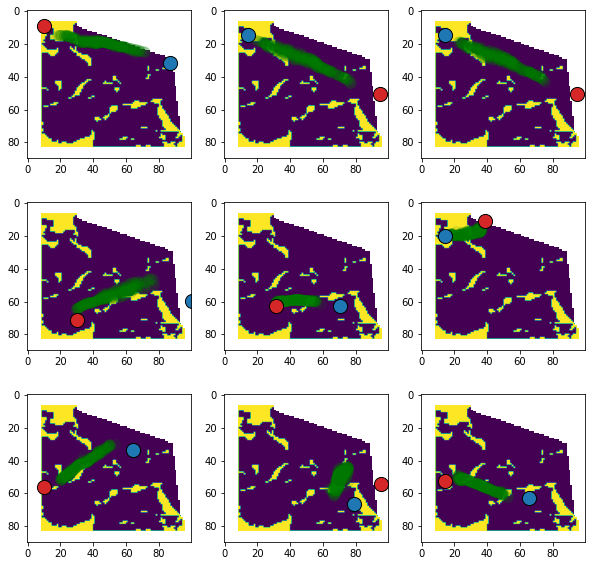

In [19]:
# Get sample condition
dataset = trainDataset

sample_idxs = np.array([
    [129, 290, 300], 
    [3290, 9140, 9990], 
    [11440, 25515, 8888],
])

fig, axs = plt.subplots(sample_idxs.shape[0], 
                        sample_idxs.shape[1],
                       figsize=(10, 10))

for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        sample_idx = sample_idxs[i, j]
        sample_X, sample_C = dataset[sample_idx]
        sample = decompose(dataset[sample_idx], occdims=occShape, verbose=True)
        printSample(sample)

        # Convert to length-1 batches for model compatability
        sample_C = torch.unsqueeze(sample_C, 0)

        # Sample latent space
        z_dim = model.latent_size
        z = torch.Tensor(np.random.randn(batchSize, z_dim))
        sample_C = torch.Tensor(np.tile(sample_C, (batchSize, 1)))
        
        model.to("cpu")
        model.eval()
        with torch.no_grad():
            res = np.array(model.decoder(z, sample_C))
           
        # Plot
        axs[i][j].scatter((res[:,0] * 100), (res[:,1] * 90), color="green", s=100, alpha=0.1);
        axs[i][j].scatter((sample["init"][0] * 100), (sample["init"][1] * 90), 
                    s=200, color="tab:red", edgecolors="black");
        axs[i][j].scatter((sample["goal"][0] * 100), (sample["goal"][1] * 90),
                    s=200, color="tab:blue", edgecolors="black");
        axs[i][j].imshow(occGrid, origin='lower');
        axs[i][j].invert_yaxis();
